# Exam project

**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [50]:
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from types import SimpleNamespace
from scipy.optimize import root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem 1: Production economy and CO2 taxation

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

To check the market clearing conditions, I will first set up the given functions, so these are defined for later use.

In [51]:
# Set up parameters
par = SimpleNamespace()
par.A = 1.0
par.gamma = 0.5
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
par.tau = 0.0
par.T = 0.0

w = 1  # Numeraire

# Define functions for optimal firm behavior
def optimal_labor(w, p, A, gamma):
    return (p * A * gamma / w)**(1 / (1 - gamma))

def optimal_output(w, p, A, gamma):
    l = optimal_labor(w, p, A, gamma)
    return A * l**gamma

def optimal_profit(w, p, A, gamma):
    l = optimal_labor(w, p, A, gamma)
    return ((1 - gamma) / gamma) * w * l

# Functions for optimal consumer behavior
def optimal_consumption1(w, T, p1, p2, tau, alpha, l):
    l1 = optimal_labor(w, p1, par.A, par.gamma)
    l2 = optimal_labor(w, p2, par.A, par.gamma)
    income = w * l + T + optimal_profit(w, p1, par.A, par.gamma) + optimal_profit(w, p2, par.A, par.gamma)
    return alpha * income / p1

def optimal_consumption2(w, T, p1, p2, tau, alpha, l):
    l1 = optimal_labor(w, p1, par.A, par.gamma)
    l2 = optimal_labor(w, p2, par.A, par.gamma)
    income = w * l + T + optimal_profit(w, p1, par.A, par.gamma) + optimal_profit(w, p2, par.A, par.gamma)
    return (1 - alpha) * income / (p2 + tau)

# Function for utility maximization
def utility(l, w, T, p1, p2, tau, alpha, nu, epsilon):
    c1 = optimal_consumption1(w, T, p1, p2, tau, alpha, l)
    c2 = optimal_consumption2(w, T, p1, p2, tau, alpha, l)
    return np.log(c1**alpha * c2**(1 - alpha)) - nu * l**(1 + epsilon) / (1 + epsilon)

# I use scipy.optimize.minimize_scalar to find the optimal labor supplied, by findind the minimum of the negative utility
def find_optimal_labor(w, T, p1, p2, tau, alpha, nu, epsilon):
    res = minimize_scalar(lambda l: -utility(l, w, T, p1, p2, tau, alpha, nu, epsilon), bounds=(0, 100), method='bounded')
    return res.x


Now I am ready to set up the functions that are required to actually check the market clearing conditions. I will define the market clearing function as *check_market_clearing* and make a loop for each price in *p1* and *p2*. The function calculates several different variables that could be interesting to look at, most importantly the *goods_market1*, *goods_market2* and the *labor_mismatch*, which are the excess demand/supply functions for each of the three variables that need to clear the markets.



In [52]:

# Define function for checking market clearing conditions
def check_market_clearing(p1_values, p2_values, par):
    results = []
    for p1 in p1_values:
        for p2 in p2_values:
            l1 = optimal_labor(w, p1, par.A, par.gamma)
            l2 = optimal_labor(w, p2, par.A, par.gamma)
            labor_demanded = l1 + l2
            l_opt = find_optimal_labor(w, par.T, p1, p2, par.tau, par.alpha, par.nu, par.epsilon)
            labor_supplied = l_opt
            goods_market1 = optimal_consumption1(w, par.T, p1, p2, par.tau, par.alpha, l_opt) - optimal_output(w, p1, par.A, par.gamma)
            goods_market2 = optimal_consumption2(w, par.T, p1, p2, par.tau, par.alpha, l_opt) - optimal_output(w, p2, par.A, par.gamma)
            util = utility(l_opt, w, par.T, p1, p2, par.tau, par.alpha, par.nu, par.epsilon)
            labor_mismatch = labor_supplied - labor_demanded
            results.append((p1, p2, labor_demanded, goods_market1, goods_market2, labor_mismatch, util))
    return results

# Range as given in exam paper
p1_values = np.linspace(0.01, 2.0, 10)
p2_values = np.linspace(0.01, 2.0, 10)

# Check market clearing for the prices and labor market mismatch
market_clearing_results = check_market_clearing(p1_values, p2_values, par)

# Convert results to DataFrame
df_results = pd.DataFrame(market_clearing_results, columns=['Price1', 'Price2', 'Labor_Demanded', 'Goods_Market1', 'Goods_Market2', 'Labor_Market_Mismatch', 'Utility'])

# Print results as strings so they are more readable
print(df_results.to_string())


      Price1    Price2  Labor_Demanded  Goods_Market1  Goods_Market2  Labor_Market_Mismatch   Utility
0   0.010000  0.010000        0.000050      29.995999      69.997332               0.999933  3.661023
1   0.010000  0.231111        0.013378      30.263202       2.940369               0.982184  1.476072
2   0.010000  0.452222        0.051151      31.026645       1.375030               0.932086  1.043154
3   0.010000  0.673333        0.113369      32.304146       0.782957               0.850233  0.823456
4   0.010000  0.894444        0.200033      34.123135       0.443077               0.737539  0.702977
5   0.010000  1.115556        0.311141      36.518417       0.206158               0.595165  0.642752
6   0.010000  1.336667        0.446694      39.529213       0.021790               0.424418  0.623186
7   0.010000  1.557778        0.606693      43.195569      -0.131805               0.226633  0.632165
8   0.010000  1.778889        0.791136      47.555508      -0.265603              

Now I have a "grid" of prices, and by examining these we can see that the true prices that clear the market should be somewhere between 0.894-1.115 for price 1 and between 1.336-1.557 for price 2. It is interesting to note that the utility achieved for the consumer is actually negative for the market clearing prices, which might suggest that I have made an error in implementing the functions somewhere, or have made some other mistake, since it does not seem reasonable that the consumer would choose a negative utility, when it is clear that a utility of 0 can be obtained by not working.

*(I might now have realized my mistake. Maybe I shouldn't minimize negative utility, since if utility is already negative, then I will simply find the utility closest to zero)*

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

Here, I will again use the a version of the clearing function, and then find the optimal prices. I will not be looking at whether the labor market clears, since if the two goods markets clear then it follows from Walras' law that the third market will also clear.

In [53]:
# Define the system of equations for market clearing again
def market_clearing_equations(prices, par):
    p1, p2 = prices
    l1 = optimal_labor(w, p1, par.A, par.gamma)
    l2 = optimal_labor(w, p2, par.A, par.gamma)
    labor_demanded = l1 + l2
    l_opt = find_optimal_labor(w, par.T, p1, p2, par.tau, par.alpha, par.nu, par.epsilon)
    labor_supplied = l_opt
    goods_market1 = optimal_consumption1(w, par.T, p1, p2, par.tau, par.alpha, l_opt) - optimal_output(w, p1, par.A, par.gamma)
    goods_market2 = optimal_consumption2(w, par.T, p1, p2, par.tau, par.alpha, l_opt) - optimal_output(w, p2, par.A, par.gamma)
    return [goods_market1, goods_market2]

# Initial guess for prices, can be anything as long is it is not 0,0
initial_guess = [1.0, 1.0]

# Solve for equilibrium prices
solution = root(market_clearing_equations, initial_guess, args=(par,))

# Check if the solution was found
if solution.success:
    equilibrium_prices = solution.x
    print(f"Equilibrium prices are p1 = {equilibrium_prices[0]}, p2 = {equilibrium_prices[1]}")
else:
    print("Equilibrium prices could not be found")



Equilibrium prices are p1 = 0.9759307031776863, p2 = 1.4907587734477428


We see now that the equilibrium prices are indeed within the ranges that I found in Question 1. Whether these are the correct prices is uncertain, since i am not sure that the consumer will choose a negative utility, which she gains from these prices.

But at least I believe that the actual code should produce the equilibrium prices, conditional on the previous code being correct.

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

This is again an optimizing problem, where I would need to maximize the SWF function, and find the optimal value of $\tau$, but unfortunately I have not managed to do that.

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


To answer question 1, I will build a simple loop for each $J$, and then compute $K=10000$ simulations for each. 

In [54]:
# Set up parameters
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

# Function to simulate utilities
def simulate_utilities(par, seed):
    np.random.seed(seed)
    simulated_utilities = np.zeros((par.J, par.K))
    for j in range(par.J):
        epsilon = np.random.normal(0, par.sigma, par.K)
        simulated_utilities[j, :] = par.v[j] + epsilon
    return simulated_utilities

# Seed to reproduce results
seed_1 = 42
seed_2 = 24

# Simulate expected utilities
simulated_utilities_1 = simulate_utilities(par, seed_1)
expected_utilities = np.mean(simulated_utilities_1, axis=1)

# Simulate average realized utilities
simulated_utilities_2 = simulate_utilities(par, seed_2)
average_realized_utilities = np.mean(simulated_utilities_2, axis=1)

# Create Pandas DataFrame
df_results = pd.DataFrame({
    'Career Path': [f'Career {j+1}' for j in range(par.J)],
    'Expected Utility': expected_utilities,
    'Average Realized Utility': average_realized_utilities
})

# Print the results so they are more readanle
print(df_results.to_string(index=False))


Career Path  Expected Utility  Average Realized Utility
   Career 1          0.995728                  0.977087
   Career 2          2.027068                  2.002534
   Career 3          2.975074                  2.982269


As it can be seen, the expected utility is very close to the *average realized utility*. This is due to the fact that the expected utility is defined as $\mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k$

On the other hand, the average realized utility is calculated as $\frac{1}{K}\sum_{k=1}^K v_j+\epsilon_{i,j}^k$, and since the value for each $v_j$ is constant, they should equal for sufficiently large values of $K$. This is due to the *Law of Large Numbers*.

This is also clear from the fact that the mean of the noise term is zero, so the asymptotic value of choosing each career path should approach $v_j$.

Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

To answer question 2, I will utilize a double nested loop. The outer loop will consist of the 10000 iterations/simulations, and the inner loop will first draw and calculate expected utility from the candidates' friends, then draw noise terms for each possible career path for each candidate, and then choose the career path with the highest expected utility. 

I have described each of them as being for year 1, since this will be needed for Question 3, so that the code there becomes cleaner.

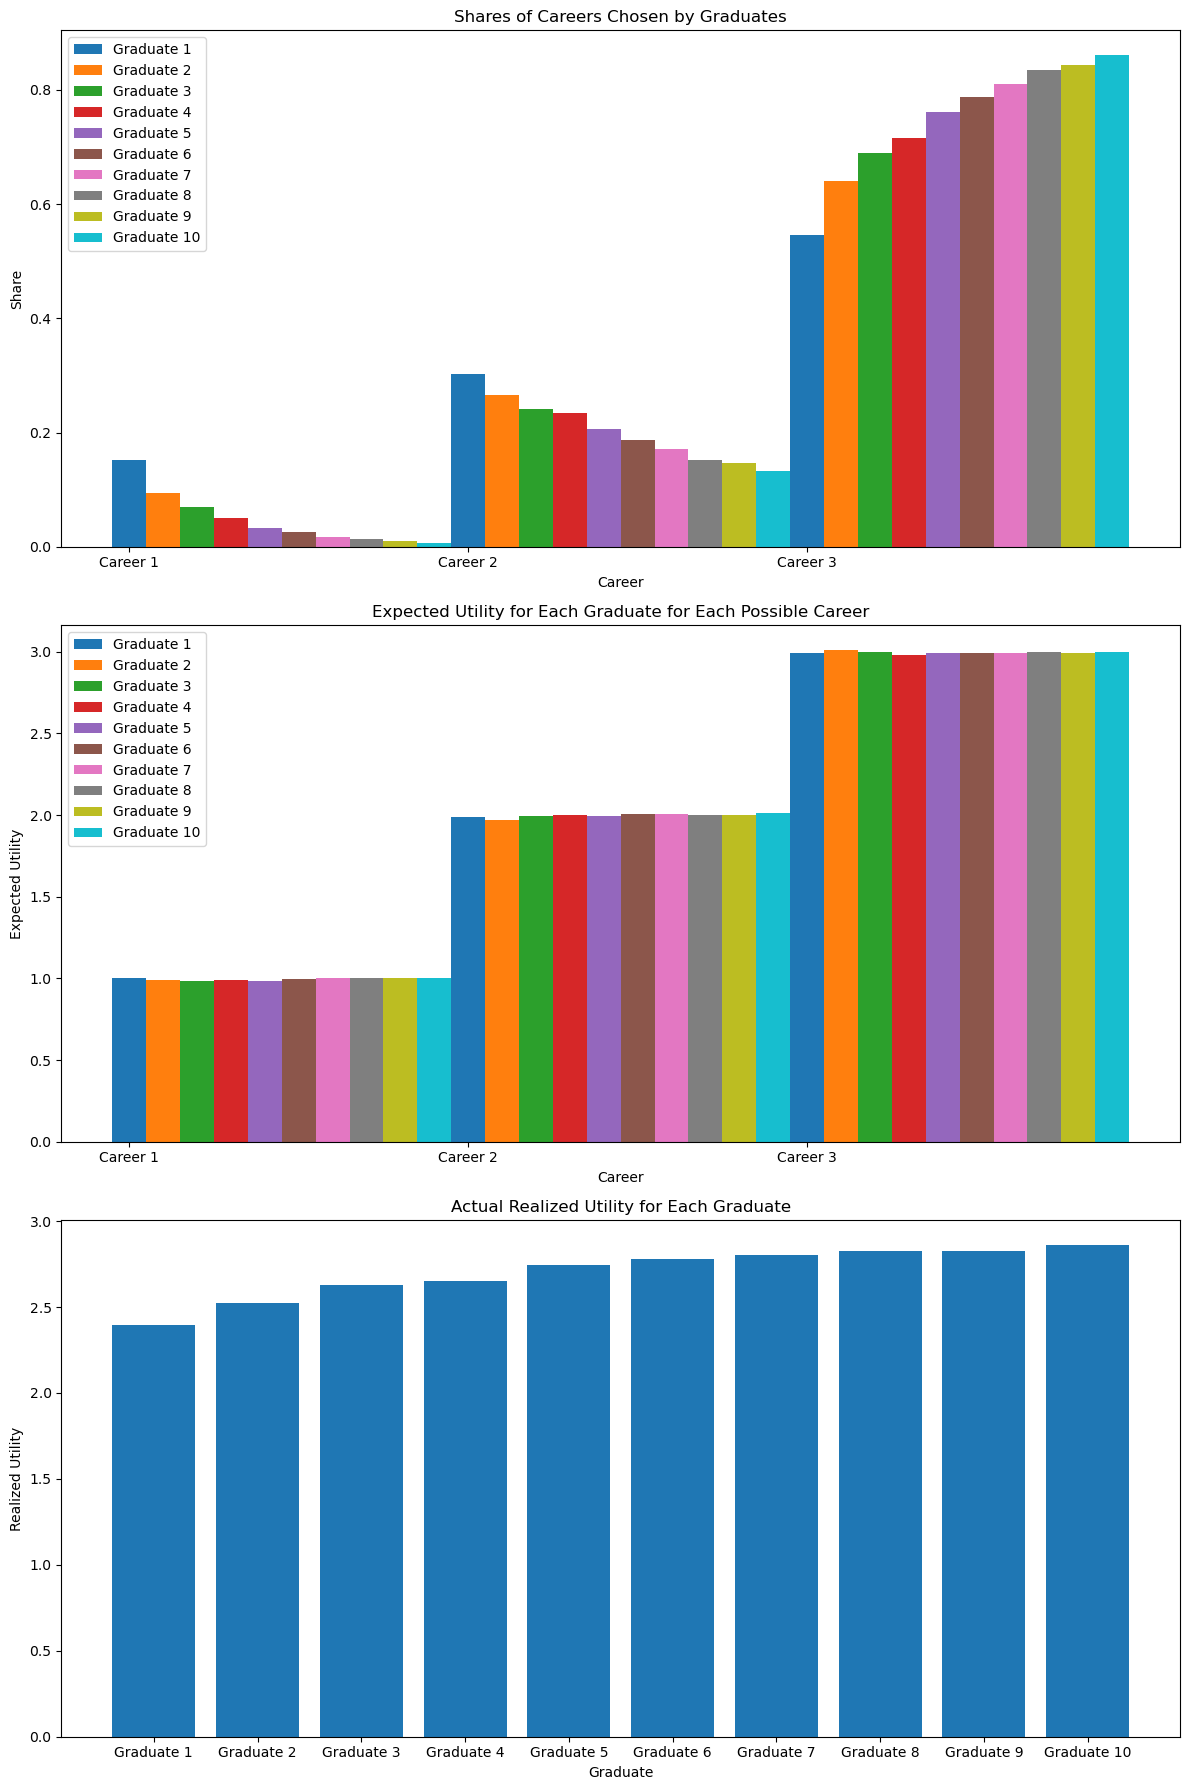

In [63]:
# Utility from friends function
def expected_utility_from_friends(num_friends, par):
    utilities = np.zeros((par.J, num_friends))
    for j in range(par.J):
        epsilon = np.random.normal(0, par.sigma, num_friends)
        utilities[j, :] = par.v[j] + epsilon
    return utilities.mean(axis=1)

# Lists with zeros to store results
all_chosen_careers_y1 = np.zeros((par.K, par.N), dtype=int)
all_expected_utilities_y1 = np.zeros((par.K, par.N, par.J))
all_realized_utilities_y1 = np.zeros((par.K, par.N))
all_noise_terms_y1 = np.zeros((par.K, par.N, par.J))

# Run simulations
for k in range(par.K):
    chosen_careers_y1 = []
    expected_utilities_y1 = []
    realized_utilities_y1 = []
    noise_terms_y1 = []

    for i in range(1, par.N + 1):
        num_friends = i  # Each graduate has 'i' number of friends
        prior_expected_utilities = expected_utility_from_friends(num_friends, par)
        own_noise = np.random.normal(0, par.sigma, par.J)
        
        # Graduate chooses the career with the highest observed utility from friends
        chosen_career = np.argmax(prior_expected_utilities)
        
        # Calculate realized utility as chosen career utility +noise term
        personal_realized_utility = par.v[chosen_career] + own_noise[chosen_career]
        
        chosen_careers_y1.append(chosen_career)
        expected_utilities_y1.append(prior_expected_utilities)
        realized_utilities_y1.append(personal_realized_utility)
        noise_terms_y1.append(own_noise)

    all_chosen_careers_y1[k, :] = chosen_careers_y1
    all_expected_utilities_y1[k, :, :] = expected_utilities_y1
    all_realized_utilities_y1[k, :] = realized_utilities_y1
    all_noise_terms_y1[k, :, :] = noise_terms_y1


# Calculate shares of careers chosen
career_shares_y1 = np.mean(all_chosen_careers_y1 == np.arange(par.J)[:, None, None], axis=1).T

# Calculate expected and realized utilities
avg_expected_utilities_y1 = np.mean(all_expected_utilities_y1, axis=0)
avg_realized_utilities_y1 = np.mean(all_realized_utilities_y1, axis=0)

# Create charts
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Share of careers chosen by graduates
for i in range(par.N):
    axes[0].bar(np.arange(par.J) + i/par.N, career_shares_y1[i], width=1/par.N, label=f'Graduate {i+1}')
axes[0].set_xticks(np.arange(par.J))
axes[0].set_xticklabels([f'Career {j+1}' for j in range(par.J)])
axes[0].set_title('Shares of Careers Chosen by Graduates')
axes[0].set_xlabel('Career')
axes[0].set_ylabel('Share')
axes[0].legend()

# Expected utility for each graduate for each possible career
for i in range(par.N):
    axes[1].bar(np.arange(par.J) + i/par.N, avg_expected_utilities_y1[i], width=1/par.N, label=f'Graduate {i+1}')
axes[1].set_xticks(np.arange(par.J))
axes[1].set_xticklabels([f'Career {j+1}' for j in range(par.J)])
axes[1].set_title('Expected Utility for Each Graduate for Each Possible Career')
axes[1].set_xlabel('Career')
axes[1].set_ylabel('Expected Utility')
axes[1].legend()

# Actual realized utility for each graduate
axes[2].bar(np.arange(par.N), avg_realized_utilities_y1)
axes[2].set_xticks(np.arange(par.N))
axes[2].set_xticklabels([f'Graduate {i+1}' for i in range(par.N)])
axes[2].set_title('Actual Realized Utility for Each Graduate')
axes[2].set_xlabel('Graduate')
axes[2].set_ylabel('Realized Utility')

plt.tight_layout()
plt.show()


What I can see from the results is that candidate 1 is clearly the one that is worst off, on average, while each successive candidate does better, as reflected by the higher average utility. 

This stems from the fact that a candidate with a higher number will have more friends in each career, and can thus have a better estimate for choosing the best career (which of course is career 3). 

While I do not see the relevance of visualizing the average expected utility, $\frac{1}{K}\sum_{k=1}^K\tilde{u}_{ij=j_i^{k*}}^k(F_i)$, it is clear that when taking the average expected utility over a large number of samples, they will each approach their true values.



After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

I will now use a thrice-nested loop for the second year, since there should be a loop for the simulations, a loop for the 10 different candidates and then a loop for each career path to check whether there should be a switching cost imposed.

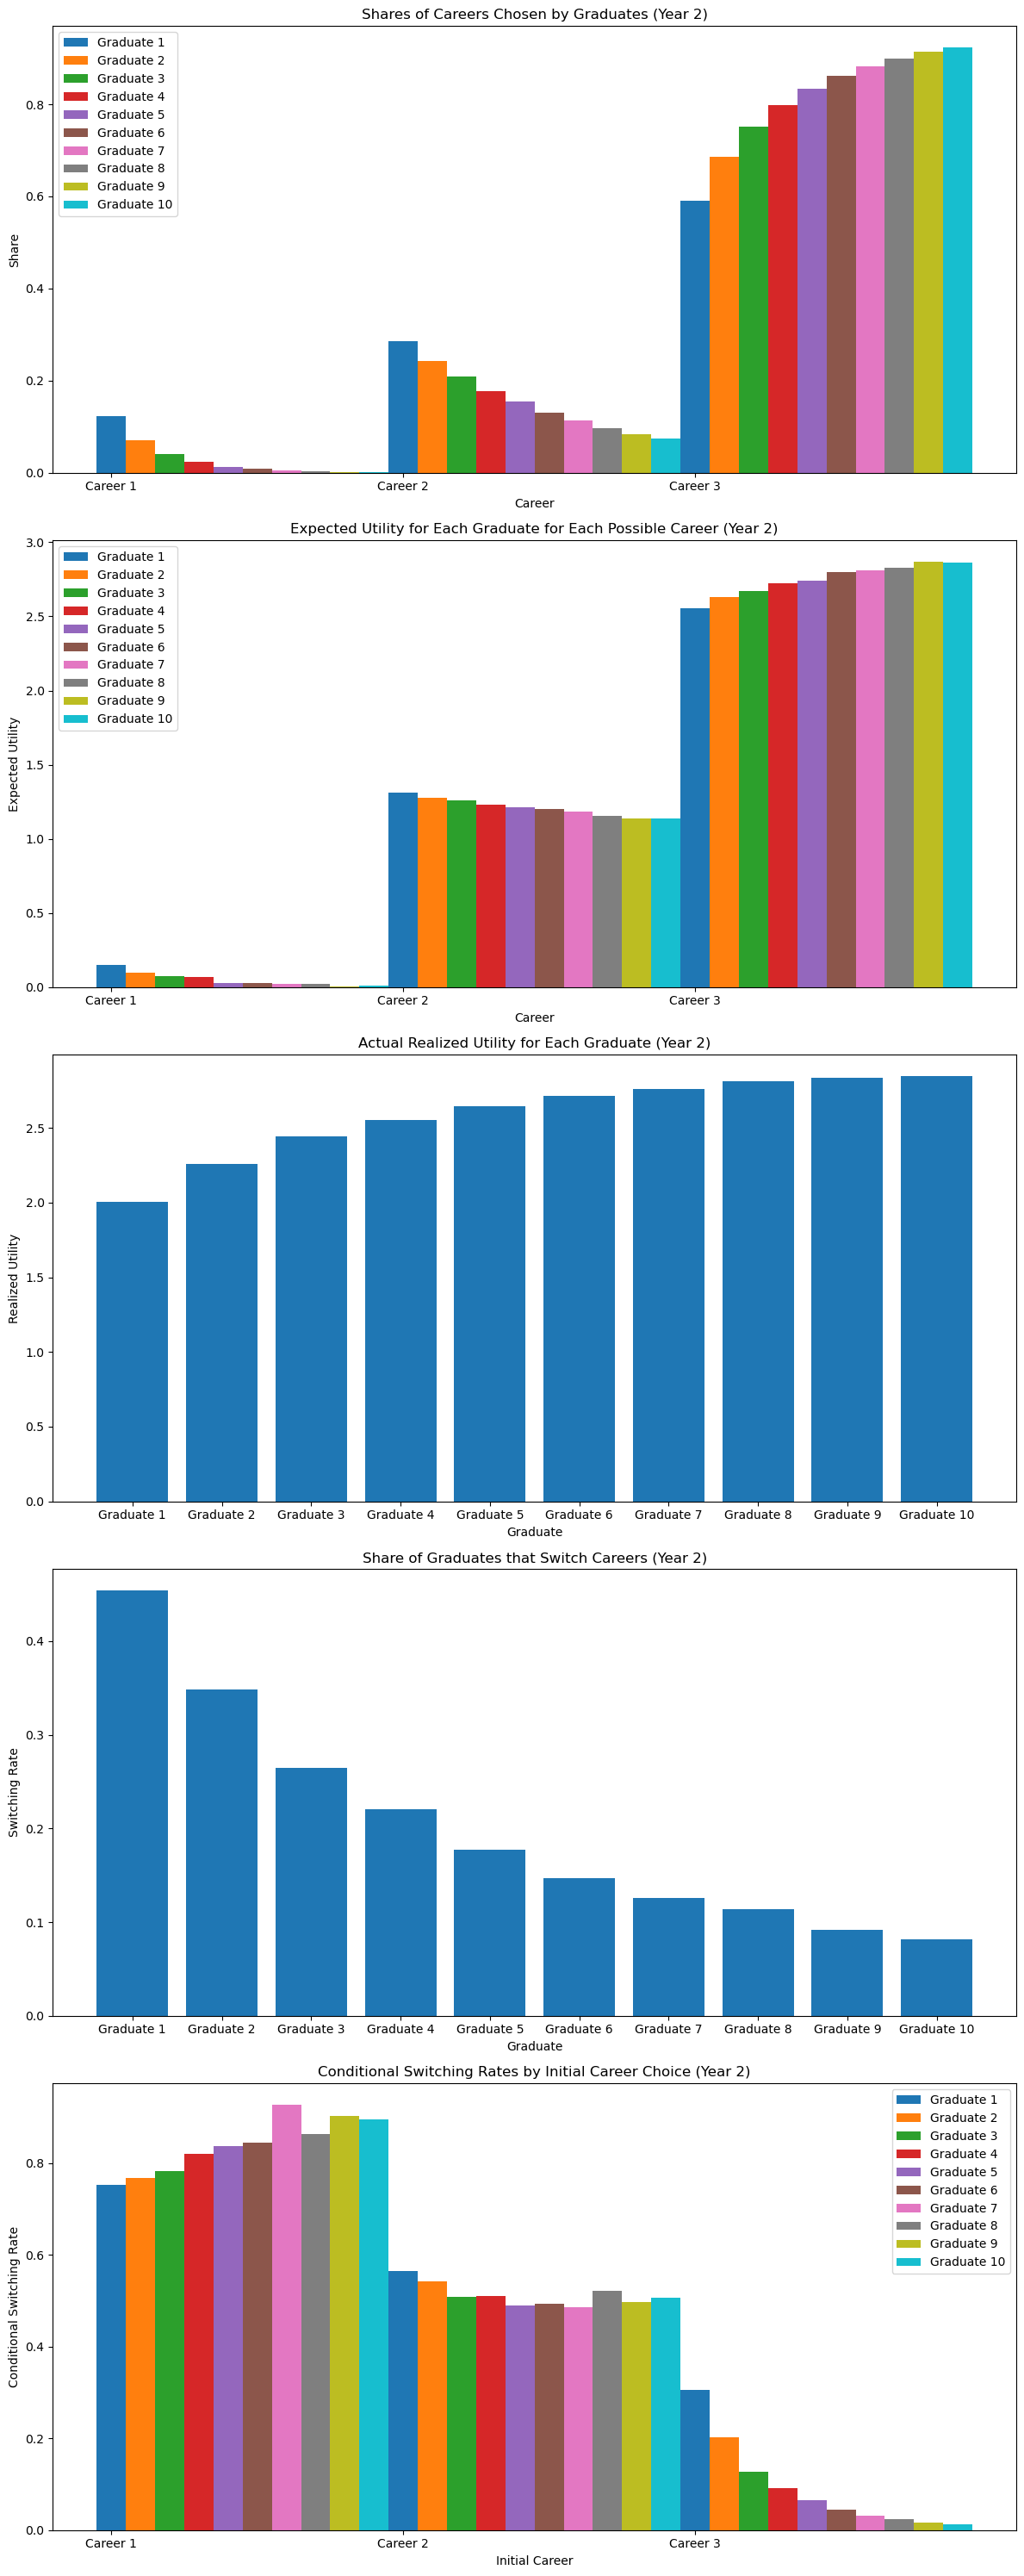

In [56]:
# Initialize lists with zeros to store results
all_chosen_careers_year2 = np.zeros((par.K, par.N), dtype=int)
all_expected_utilities_year2 = np.zeros((par.K, par.N, par.J))
all_realized_utilities_year2 = np.zeros((par.K, par.N))
switch_counts = np.zeros((par.N, par.J), dtype=int)
initial_counts = np.zeros((par.N, par.J), dtype=int)

# Run simulations for the second year
for k in range(par.K):
    chosen_careers_year2 = []
    expected_utilities_year2 = []
    realized_utilities_year2 = []

    for i in range(par.N):
        chosen_career_y1 = all_chosen_careers_y1[k, i]
        num_friends = i + 1 
        
        # reuse prior expected probabilities
        prior_expected_utilities = expected_utility_from_friends(num_friends, par)
        
        # Update expected utilities with switching cost for non-chosen careers
        new_expected_utilities = np.copy(prior_expected_utilities)
        new_noises = all_noise_terms_y1[k, i, :]  # Use saved noise terms
        
        for j in range(par.J):
            if j != chosen_career_y1:
                new_expected_utilities[j] -= par.c


        # Graduate chooses the optimal career by choosing highest observed utility from friends minus switching costs
        chosen_career = np.argmax(new_expected_utilities)
        
        # Calculate realized utility as the chosen career utility + own noise term
        if chosen_career != chosen_career_y1:
            personal_realized_utility = par.v[chosen_career] + new_noises[chosen_career] - par.c
            switch_counts[i, chosen_career_y1] += 1
        else:
            personal_realized_utility = par.v[chosen_career] + new_noises[chosen_career]

        initial_counts[i, chosen_career_y1] += 1
        
        chosen_careers_year2.append(chosen_career)
        expected_utilities_year2.append(new_expected_utilities)
        realized_utilities_year2.append(personal_realized_utility)

    all_chosen_careers_year2[k, :] = chosen_careers_year2
    all_expected_utilities_year2[k, :, :] = expected_utilities_year2
    all_realized_utilities_year2[k, :] = realized_utilities_year2

# Calculate shares of careers chosen
career_shares_year2 = np.mean(all_chosen_careers_year2 == np.arange(par.J)[:, None, None], axis=1).T

avg_expected_utilities_year2 = np.mean(all_expected_utilities_year2, axis=0)
avg_realized_utilities_year2 = np.mean(all_realized_utilities_year2, axis=0)

switching_rates = np.mean(all_chosen_careers_y1 != all_chosen_careers_year2, axis=0)

# Calculate conditional switching rates
conditional_switching_rates = np.zeros((par.N, par.J))
for i in range(par.N):
    for j in range(par.J):
        if initial_counts[i, j] > 0:
            conditional_switching_rates[i, j] = switch_counts[i, j] / initial_counts[i, j]

fig, axes = plt.subplots(5, 1, figsize=(12, 30))

# Share of careers chosen by graduates in year 2
for i in range(par.N):
    axes[0].bar(np.arange(par.J) + i/par.N, career_shares_year2[i], width=1/par.N, label=f'Graduate {i+1}')
axes[0].set_xticks(np.arange(par.J))
axes[0].set_xticklabels([f'Career {j+1}' for j in range(par.J)])
axes[0].set_title('Shares of Careers Chosen by Graduates (Year 2)')
axes[0].set_xlabel('Career')
axes[0].set_ylabel('Share')
axes[0].legend()

# Expected utility for each graduate for each possible career in year 2
for i in range(par.N):
    axes[1].bar(np.arange(par.J) + i/par.N, avg_expected_utilities_year2[i], width=1/par.N, label=f'Graduate {i+1}')
axes[1].set_xticks(np.arange(par.J))
axes[1].set_xticklabels([f'Career {j+1}' for j in range(par.J)])
axes[1].set_title('Expected Utility for Each Graduate for Each Possible Career (Year 2)')
axes[1].set_xlabel('Career')
axes[1].set_ylabel('Expected Utility')
axes[1].legend()

# Actual realized utility for each graduate in year 2
axes[2].bar(np.arange(par.N), avg_realized_utilities_year2)
axes[2].set_xticks(np.arange(par.N))
axes[2].set_xticklabels([f'Graduate {i+1}' for i in range(par.N)])
axes[2].set_title('Actual Realized Utility for Each Graduate (Year 2)')
axes[2].set_xlabel('Graduate')
axes[2].set_ylabel('Realized Utility')

# Share of graduates that switch careers in year 2
axes[3].bar(np.arange(par.N), switching_rates)
axes[3].set_xticks(np.arange(par.N))
axes[3].set_xticklabels([f'Graduate {i+1}' for i in range(par.N)])
axes[3].set_title('Share of Graduates that Switch Careers (Year 2)')
axes[3].set_xlabel('Graduate')
axes[3].set_ylabel('Switching Rate')

# Conditional switching rates
for i in range(par.N):
    axes[4].bar(np.arange(par.J) + i/par.N, conditional_switching_rates[i], width=1/par.N, label=f'Graduate {i+1}')
axes[4].set_xticks(np.arange(par.J))
axes[4].set_xticklabels([f'Career {j+1}' for j in range(par.J)])
axes[4].set_title('Conditional Switching Rates by Initial Career Choice (Year 2)')
axes[4].set_xlabel('Initial Career')
axes[4].set_ylabel('Conditional Switching Rate')
axes[4].legend()

plt.tight_layout()
plt.show()




What we see is that the expected utility for choosing career 1 is very close to zero for all graduates, but it is noticable higher for graduate 1. The reason for the expected utility to be close to zero is that there was not a lot of graduates even choosing career 1 in the first place, and since these will now incur a switching cost , it is obvious that the utility should then be close to zero. 

We also see that it is mostly graduate 1 that is switching careers, which is due to the fact that graduate 1 is the one with the lowest information about the different careers, since they only have one friend from each career.

Furthermore, it is clear that most candidates choose to switch away from their career in year 1, if that career was career 1.

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [57]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Question 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

I am doing question 1 and 2 together. I will first define the distance function to be used inside the functions for A, B, C and D. Then I define the points and find the barycentric coordinates for the two triangles.

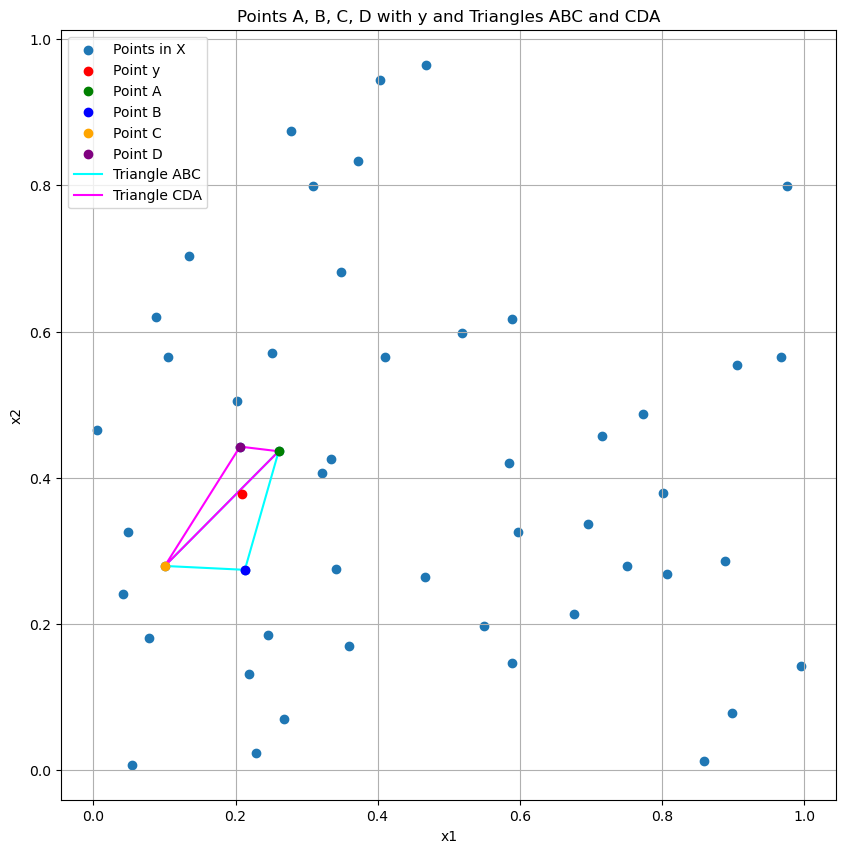

Point y: [0.20901926 0.37774759]
Point A: [0.26071605 0.43635845], Point B: [0.21315735 0.274245  ], Point C: [0.10056103 0.27951775], Point D: [0.20634391 0.44272557]
Barycentric coordinates for triangle ABC: (0.6286263152916166, 0.06910145494351515, 0.3022722297648682), inside ABC: True
Barycentric coordinates for triangle CDA: (0.3682598757102867, -0.13392661883334067, 0.765666743123054), inside CDA: False


In [58]:
import numpy as np
import matplotlib.pyplot as plt

# set seed as given
rng = np.random.default_rng(2024)

# Generate random points in the unit square as given
X = rng.uniform(size=(50, 2))
y = rng.uniform(size=(2,))

# Define the distance function
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Find A, B, C, and D
A = min([point for point in X if point[0] > y[0] and point[1] > y[1]], key=lambda point: distance(point, y))
B = min([point for point in X if point[0] > y[0] and point[1] < y[1]], key=lambda point: distance(point, y))
C = min([point for point in X if point[0] < y[0] and point[1] < y[1]], key=lambda point: distance(point, y))
D = min([point for point in X if point[0] < y[0] and point[1] > y[1]], key=lambda point: distance(point, y))

# Function to calculate barycentric coordinates
def barycentric_coordinates(A, B, C, y):
    denom = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    r1 = ((B[1] - C[1]) * (y[0] - C[0]) + (C[0] - B[0]) * (y[1] - C[1])) / denom
    r2 = ((C[1] - A[1]) * (y[0] - C[0]) + (A[0] - C[0]) * (y[1] - C[1])) / denom
    r3 = 1 - r1 - r2
    return r1, r2, r3

# calculate barycentric coordinates for both triangles
rABC = barycentric_coordinates(A, B, C, y)
rCDA = barycentric_coordinates(C, D, A, y)

# Check if y is inside any of the triangles
def is_inside_triangle(r):
    return all(0 <= coord <= 1 for coord in r)

inside_ABC = is_inside_triangle(rABC)
inside_CDA = is_inside_triangle(rCDA)

# make plot
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], label='Points in X')
plt.scatter(y[0], y[1], color='red', label='Point y', zorder=5)
plt.scatter(A[0], A[1], color='green', label='Point A', zorder=5)
plt.scatter(B[0], B[1], color='blue', label='Point B', zorder=5)
plt.scatter(C[0], C[1], color='orange', label='Point C', zorder=5)
plt.scatter(D[0], D[1], color='purple', label='Point D', zorder=5)
plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], label='Triangle ABC', color='cyan')
plt.plot([C[0], D[0], A[0], C[0]], [C[1], D[1], A[1], C[1]], label='Triangle CDA', color='magenta')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Points A, B, C, D with y and Triangles ABC and CDA')
plt.grid(True)
plt.show()

print(f"Point y: {y}")
print(f"Point A: {A}, Point B: {B}, Point C: {C}, Point D: {D}")
print(f"Barycentric coordinates for triangle ABC: {rABC}, inside ABC: {inside_ABC}")
print(f"Barycentric coordinates for triangle CDA: {rCDA}, inside CDA: {inside_CDA}")


As we can see, the point y is inside triangle *ABC*.

Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [59]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

I set up the algorithm as outlined in the exam paper.

In [60]:
# Algo setup
if A is None or B is None or C is None or D is None:
    interpolated_value = np.nan
else:
    def barycentric_coordinates(A, B, C, y):
        denom = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
        r1 = ((B[1] - C[1]) * (y[0] - C[0]) + (C[0] - B[0]) * (y[1] - C[1])) / denom
        r2 = ((C[1] - A[1]) * (y[0] - C[0]) + (A[0] - C[0]) * (y[1] - C[1])) / denom
        r3 = 1 - r1 - r2
        return r1, r2, r3
    
    rABC = barycentric_coordinates(A, B, C, y)
    rCDA = barycentric_coordinates(C, D, A, y)

    def is_inside_triangle(r):
        return all(0 <= coord <= 1 for coord in r)

    inside_ABC = is_inside_triangle(rABC)
    inside_CDA = is_inside_triangle(rCDA)


    # Compute interpolated function value
    if inside_ABC:
        interpolated_value = rABC[0] * f(A) + rABC[1] * f(B) + rABC[2] * f(C)
    elif inside_CDA:
        interpolated_value = rCDA[0] * f(C) + rCDA[1] * f(D) + rCDA[2] * f(A)
    else:
        interpolated_value = np.nan

# True value of f(y) to compare with
f_true = f(y)

# Output the results
results = {
    "Point y": y,
    "Point A": A, "Point B": B, "Point C": C, "Point D": D,
    "Barycentric coordinates for triangle ABC": rABC if A is not None and B is not None and C is not None else None,
    "Inside ABC": inside_ABC if A is not None and B is not None and C is not None else None,
    "Barycentric coordinates for triangle CDA": rCDA if C is not None and D is not None and A is not None else None,
    "Inside CDA": inside_CDA if C is not None and D is not None and A is not None else None,
    "Interpolated value at y": interpolated_value,
    "True value at y": f_true
}

results


{'Point y': array([0.20901926, 0.37774759]),
 'Point A': array([0.26071605, 0.43635845]),
 'Point B': array([0.21315735, 0.274245  ]),
 'Point C': array([0.10056103, 0.27951775]),
 'Point D': array([0.20634391, 0.44272557]),
 'Barycentric coordinates for triangle ABC': (0.6286263152916166,
  0.06910145494351515,
  0.3022722297648682),
 'Inside ABC': True,
 'Barycentric coordinates for triangle CDA': (0.3682598757102867,
  -0.13392661883334067,
  0.765666743123054),
 'Inside CDA': False,
 'Interpolated value at y': 0.08405201731052576,
 'True value at y': 0.0789565216259594}

As seen above, the algo does as it should. It returns the "truth", that the point is inside triangle *ABC*, and we can see that the interpolated value is quite close to the true value, as it is only approx. 0.01 away.

**Question 4:** Repeat question 3 for all points in the set $Y$.

Now I will do the same for the set of points in $Y$.

In [61]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [62]:
def barycentric_coordinates(A, B, C, y):
    denom = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    r1 = ((B[1] - C[1]) * (y[0] - C[0]) + (C[0] - B[0]) * (y[1] - C[1])) / denom
    r2 = ((C[1] - A[1]) * (y[0] - C[0]) + (A[0] - C[0]) * (y[1] - C[1])) / denom
    r3 = 1 - r1 - r2
    return r1, r2, r3


# Define algo
def interpolate_value(y):
    # Find A, B, C, and D
    A_idx = min([i for i, point in enumerate(X) if point[0] > y[0] and point[1] > y[1]], key=lambda i: distance(X[i], y), default=None)
    B_idx = min([i for i, point in enumerate(X) if point[0] > y[0] and point[1] < y[1]], key=lambda i: distance(X[i], y), default=None)
    C_idx = min([i for i, point in enumerate(X) if point[0] < y[0] and point[1] < y[1]], key=lambda i: distance(X[i], y), default=None)
    D_idx = min([i for i, point in enumerate(X) if point[0] < y[0] and point[1] > y[1]], key=lambda i: distance(X[i], y), default=None)

    # Retrieve the points from X and their function values from F
    A, fA = (X[A_idx], F[A_idx]) if A_idx is not None else (None, None)
    B, fB = (X[B_idx], F[B_idx]) if B_idx is not None else (None, None)
    C, fC = (X[C_idx], F[C_idx]) if C_idx is not None else (None, None)
    D, fD = (X[D_idx], F[D_idx]) if D_idx is not None else (None, None)

    # Check if all points A, B, C, and D were found, else return NaN
    if A is None or B is None or C is None or D is None:
        return np.nan

    rABC = barycentric_coordinates(A, B, C, y)
    rCDA = barycentric_coordinates(C, D, A, y)

    inside_ABC = is_inside_triangle(rABC)
    inside_CDA = is_inside_triangle(rCDA)

    if inside_ABC:
        interpolated_value = rABC[0] * fA + rABC[1] * fB + rABC[2] * fC
    elif inside_CDA:
        interpolated_value = rCDA[0] * fC + rCDA[1] * fD + rCDA[2] * fA
    else:
        interpolated_value = np.nan

    return interpolated_value


# Loop for interpolations
results = []
for y in Y:
    interpolated_value = interpolate_value(np.array(y))
    true_value = f(np.array(y))
    results.append({
        "Point y": y,
        "Interpolated value": interpolated_value,
        "True value": true_value,
        "Difference": abs(interpolated_value - true_value)
    })

results


[{'Point y': (0.2, 0.2),
  'Interpolated value': 0.04032631372248057,
  'True value': 0.04000000000000001,
  'Difference': 0.0003263137224805632},
 {'Point y': (0.8, 0.2),
  'Interpolated value': 0.15874233999349835,
  'True value': 0.16000000000000003,
  'Difference': 0.0012576600065016819},
 {'Point y': (0.8, 0.8),
  'Interpolated value': nan,
  'True value': 0.6400000000000001,
  'Difference': nan},
 {'Point y': (0.8, 0.2),
  'Interpolated value': 0.15874233999349835,
  'True value': 0.16000000000000003,
  'Difference': 0.0012576600065016819},
 {'Point y': (0.5, 0.5),
  'Interpolated value': 0.2512901561119622,
  'True value': 0.25,
  'Difference': 0.001290156111962204}]

I conclude that the algo is working correctly. It returns NaN for $(0.8, 0.8)$ since it is clear that there is no possible point *A*, which would be located "north-east" of the point *y*.